In [ ]:
#!pip install r5py rasterio shapely

#!pip install contextily


In [12]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, box, LineString
from sklearn.neighbors import NearestNeighbors
import datetime
import r5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [13]:
# Load address points and transport stops from GPKG
buildings_gpkg_path = "output/residential_typologies.gpkg"
train_stops_geojson_path = "data/train_stations.geojson"
bus_stops_geojson_path = "data/bus_stations.geojson"
raster_gpkg_path = "data/current_state.gpkg"
raster_layer_name = "rare event (38 °C) - UTCI"

In [14]:


# Initialize r5py TransportNetwork
osm_path = "data/RiodeJaneiro.osm.pbf"
r5_network = r5py.TransportNetwork(osm_path)


In [15]:
addresses = gpd.read_file(buildings_gpkg_path)

addresses.to_crs(epsg=3857, inplace= True)
# Step 1: Save the original geometry in a new column
addresses['original_geometry'] = addresses['geometry']

# Step 2: Convert the original geometry column to its centroid
addresses['geometry'] = addresses['geometry'].centroid

# Now, the 'geometry' column contains the centroids, and the original geometries are saved in 'original_geometry'.


In [ ]:
#importing heat cells raster and converting it to CRS of addresses
raster = gpd.read_file(raster_gpkg_path, layer=raster_layer_name)
raster=raster.to_crs(addresses.crs)

Preparing addresses for processing by r5py:

In [10]:
#addresses=addresses.head(10)

addresses.reset_index(drop=True, inplace= True)
addresses.loc[:,'id']=addresses.index

Merging trains and bus stops

In [10]:
train_stops = gpd.read_file(train_stops_geojson_path)
train_stops=train_stops.to_crs(epsg=3857)

train_stops=train_stops[['objectid','cod','nome','geometry']]

train_stops.rename(columns={"nome": "stop_name"}, inplace= True)
train_stops['type']="train_station"

bus_stops = gpd.read_file(bus_stops_geojson_path)

bus_stops['type']="bus_station"
bus_stops=bus_stops.to_crs(epsg=3857)

# Combine train and bus stops into a single GeoDataFrame
transport_stops = gpd.GeoDataFrame(pd.concat([train_stops, bus_stops], ignore_index=True))
transport_stops.to_crs(epsg=3857, inplace=True)
transport_stops.reset_index(drop=True)
transport_stops.loc[:,'id']=transport_stops.index

(10, 44)

Setting a departure time (required by r5py):

In [11]:
departure = datetime.datetime(2023, 4, 1, 8, 30)

Defining the optional plot function of each route and intersections. It is commented out in the calcuate_mhi() function, but can be enabled for debugging or visualization (only useful with smaller subsets of data)

In [25]:
import contextily as ctx

def plot_route_and_cells(route, cells_within_bbox, destination_point, origin_point, intersections):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    
    # Add ESRI Dark basemap
    # Ensure CRS matches for the basemap
    ax.set_aspect('equal')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    route=gpd.GeoSeries([route])
    route.crs = 'EPSG:3857' 
    #route = route.to_crs(epsg=3857)
    
    cells_within_bbox = cells_within_bbox.to_crs(epsg=3857)
    
    ####
    # Define a colormap and normalization
    cmap = plt.get_cmap('coolwarm')  # Red to green colormap (reversed)
    norm = plt.Normalize(vmin=cells_within_bbox['utci_mean'].min(), vmax=cells_within_bbox['utci_mean'].max())
    
    # Plot cells within bounding box with gradient colors
    cells_within_bbox.plot(ax=ax, column='utci_mean', cmap=cmap, norm=norm, edgecolor='black', alpha=0.5, legend=True)
    ####
    
    ctx.add_basemap(ax, crs='EPSG:3857', source=ctx.providers.Esri.WorldGrayCanvas, alpha=0.7)
    
    
    
    # Plot the route
    route.plot(ax=ax, color='red', linewidth=2,zorder=2)
    
    # Plot the destination point
    destination_gdf = gpd.GeoDataFrame(geometry=[destination_point], crs='EPSG:3857')
    #destination_gdf=destination_gdf.to_crs(epsg=3857)
    destination_gdf.plot(ax=ax,
                         color='green',
                         markersize=100,
                         edgecolor='none',
                         label='Destination Point',alpha=1,zorder=3)
    
    origin_gdf = gpd.GeoDataFrame(geometry=[origin_point], crs='EPSG:3857')
    #destination_gdf=destination_gdf.to_crs(epsg=3857)
    origin_gdf.plot(ax=ax,
                         color='red',
                         markersize=100,
                         edgecolor='none',
                         label='Origin Point',alpha=1,zorder=3)
    
    
    intersections_gdf = gpd.GeoDataFrame(geometry=intersections, crs='EPSG:3857')
    
    intersections_gdf.plot(ax=ax,
                        color='blue',
                        markersize=50,
                        edgecolor='none',
                        label='Intersections',alpha=1,zorder=3)
    # Create custom legend handles
    cells_patch = mpatches.Patch(color='lightgrey', label='Cells')
    route_patch = mpatches.Patch(color='red', label='Route')
    
    plt.legend(handles=[cells_patch, route_patch])
    plt.title("Route and Cells within Bounding Box")
    plt.suptitle(f"MHI value: {mhi}", y=0.95, fontsize=12)
    
    # Set limits slightly bigger than total bounds
    total_bounds = cells_within_bbox.total_bounds
    x_margin = (total_bounds[2] - total_bounds[0]) * 0.05  # 5% margin
    y_margin = (total_bounds[3] - total_bounds[1]) * 0.05  # 5% margin
    ax.set_xlim(total_bounds[0] - x_margin, total_bounds[2] + x_margin)
    ax.set_ylim(total_bounds[1] - y_margin, total_bounds[3] + y_margin)
    plt.show()


In [30]:
def transform_route(route):
    source_crs = CRS("EPSG:4326")  # WGS 84
    target_crs = CRS("EPSG:3857")  # Web Mercator
    #print(route.bounds)
    # Create a transformer object
    transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)
    
    # Transform the LineString
    route_projected = LineString([transformer.transform(*coord) for coord in route.coords])
    return route_projected

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


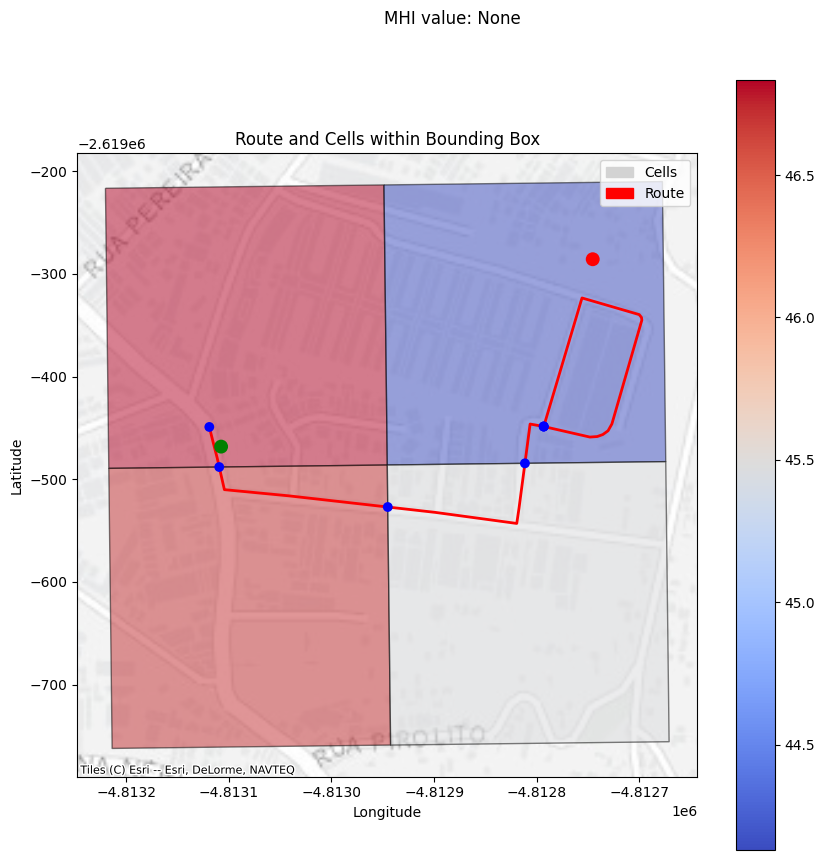

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


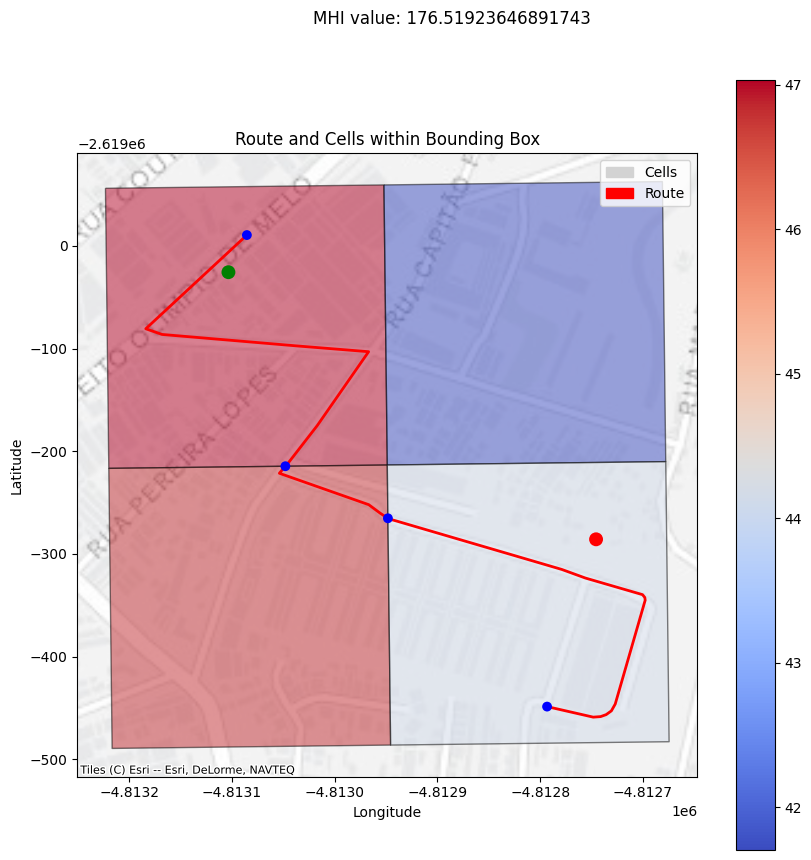

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


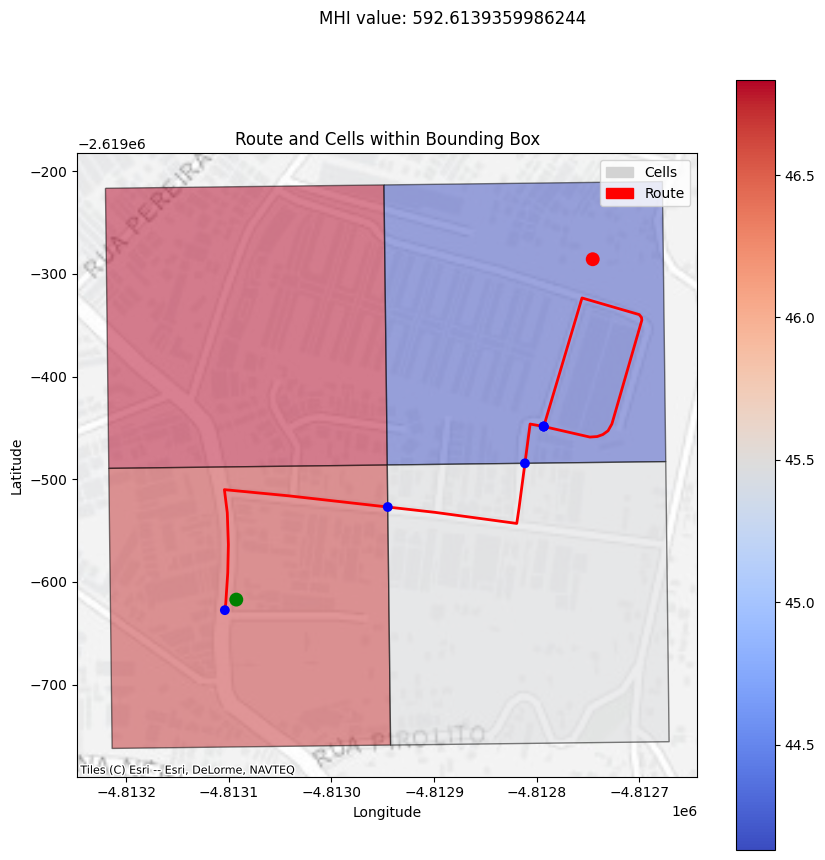

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


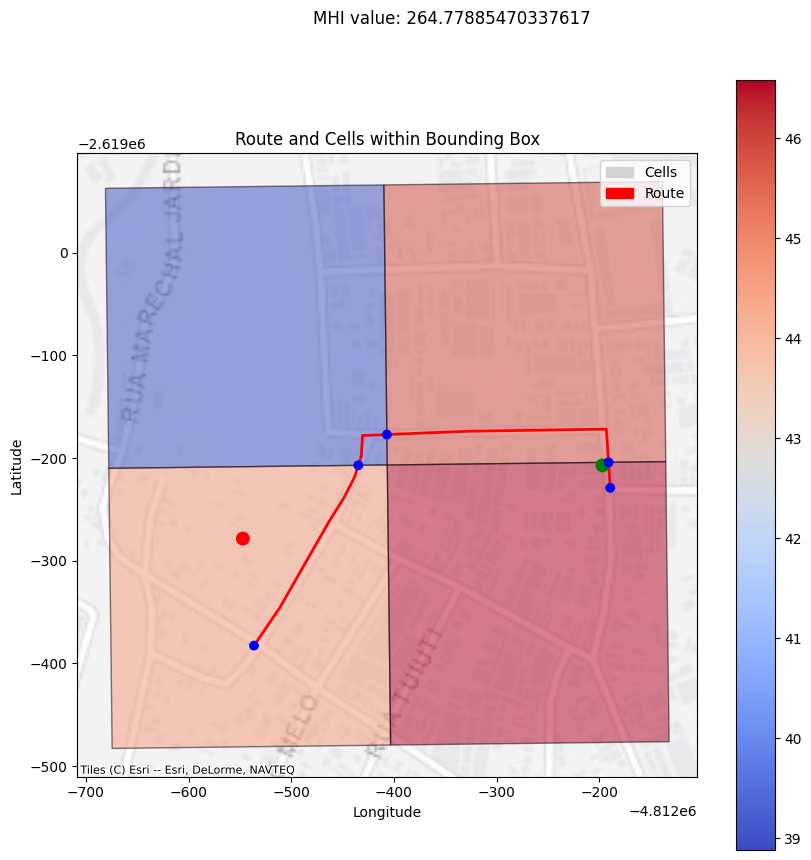

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 17 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


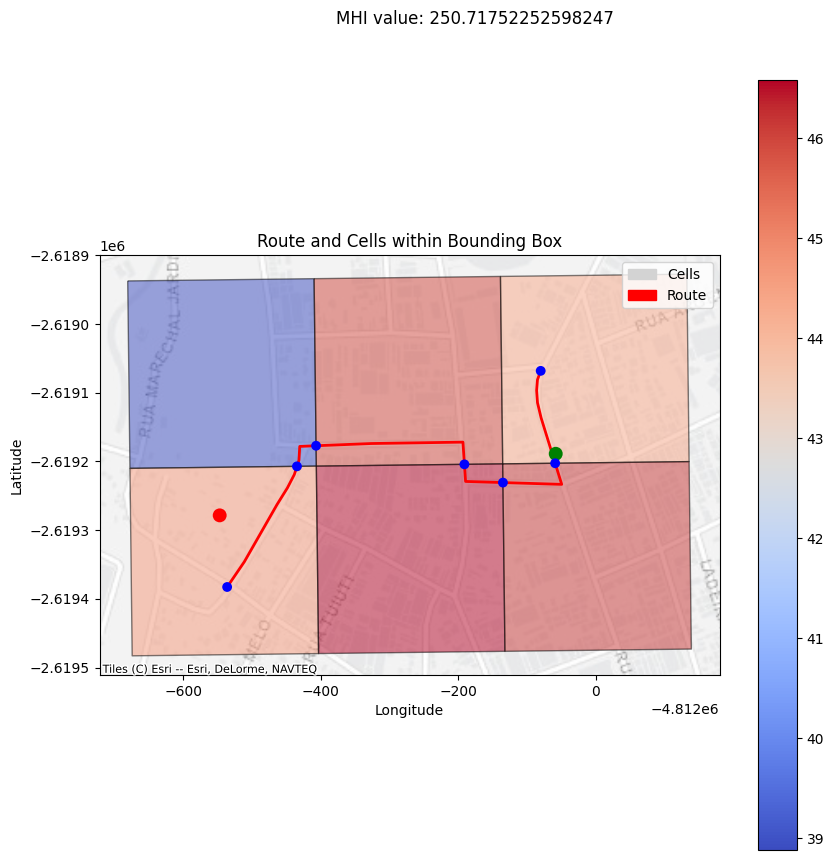

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 17 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


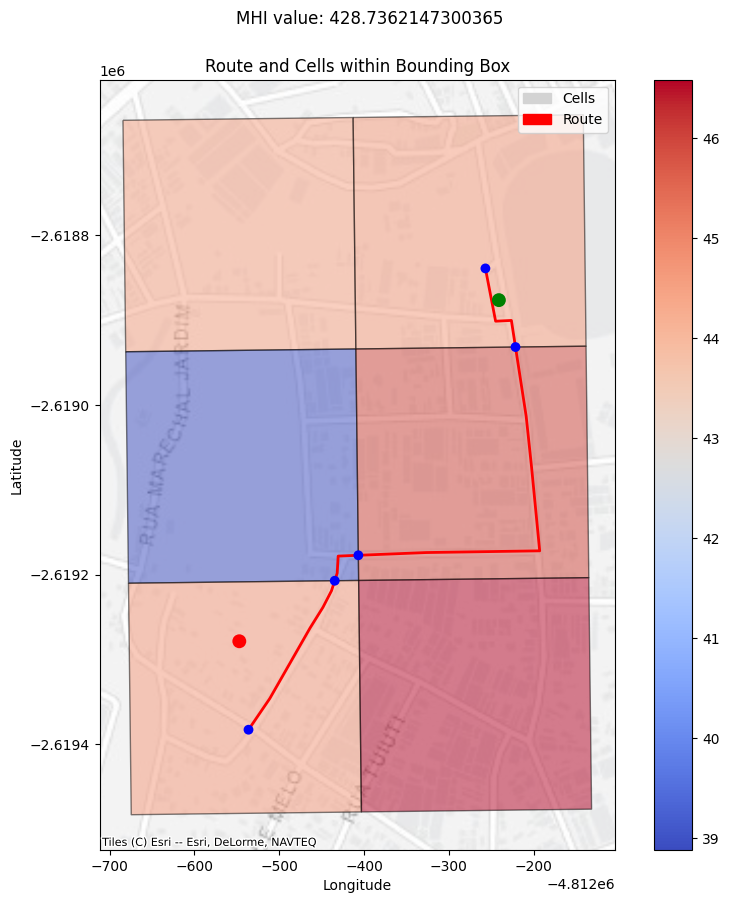

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


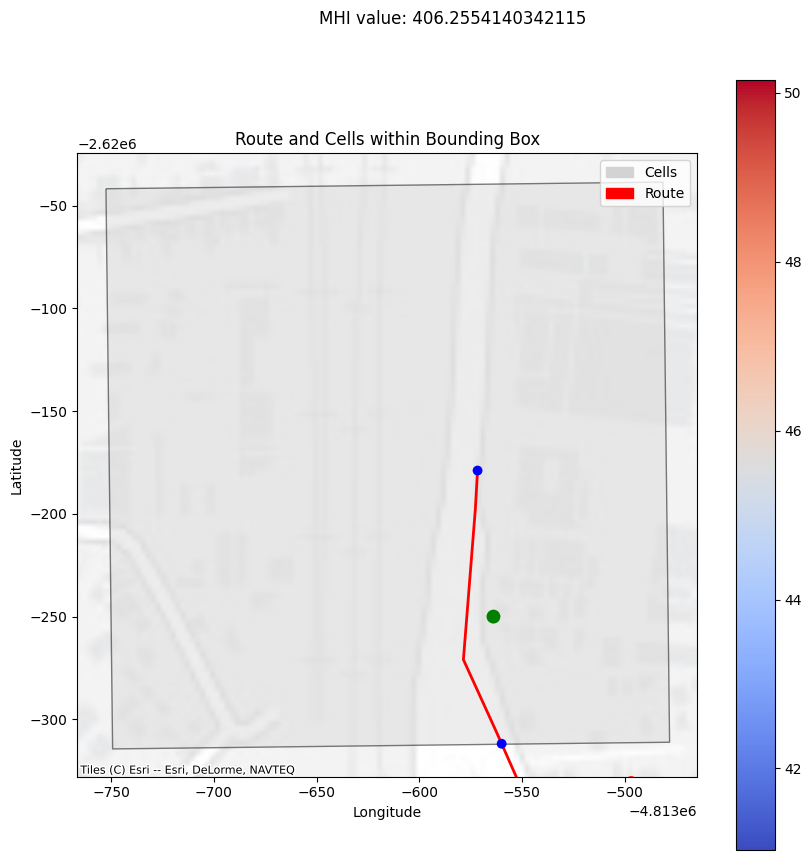

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 17 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


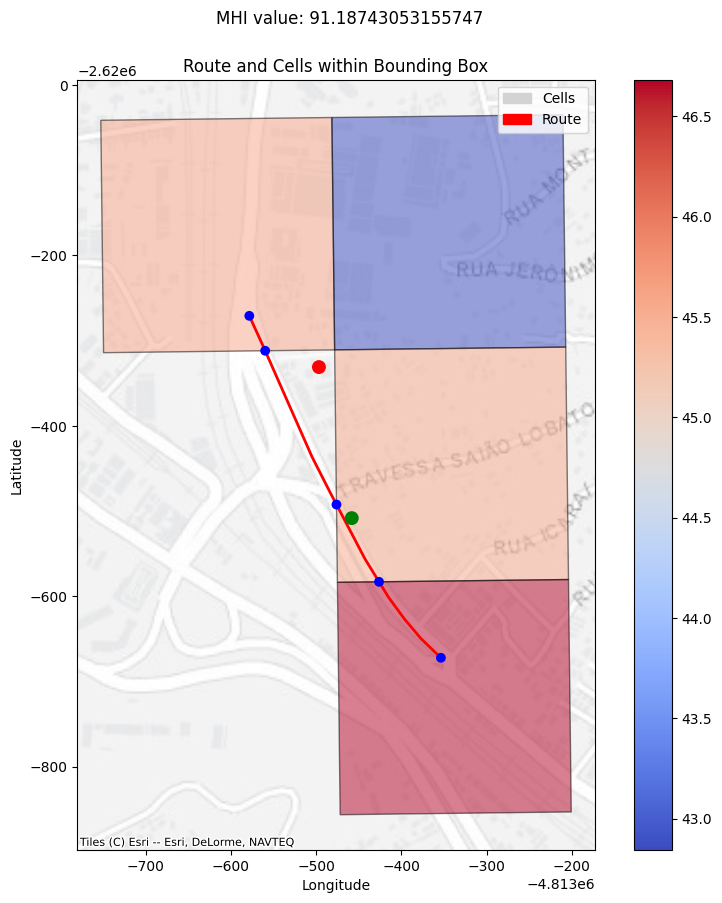

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


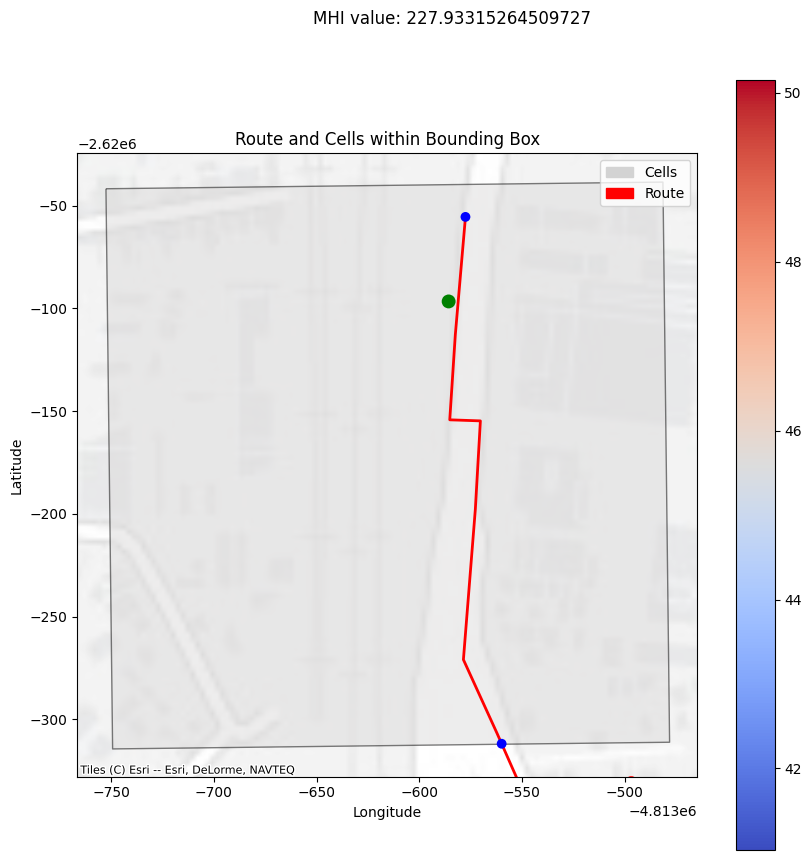

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


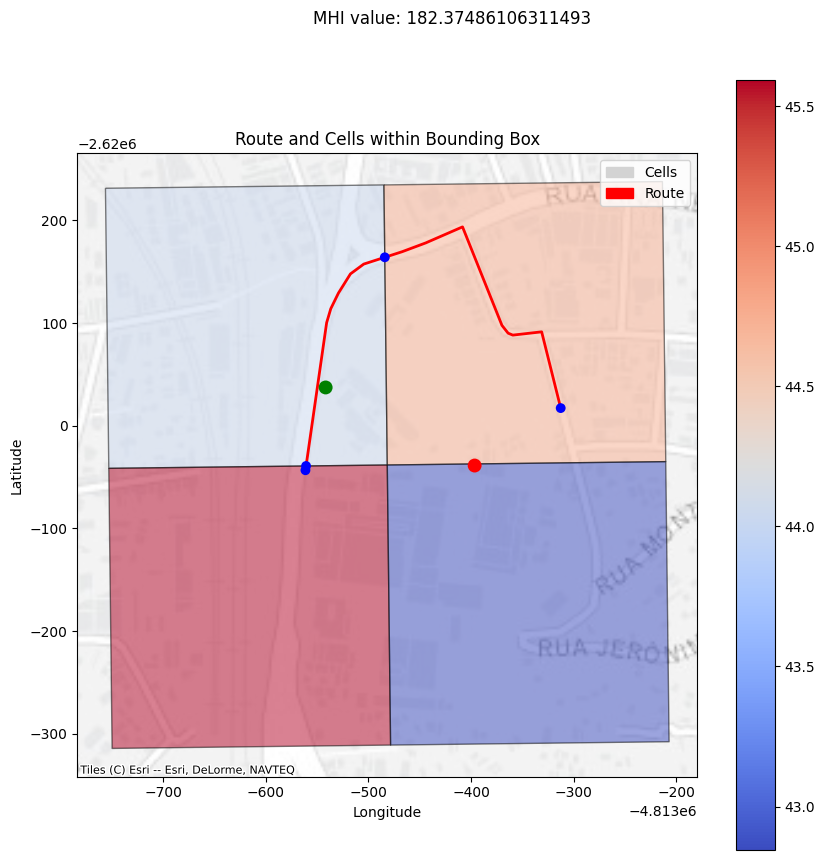

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


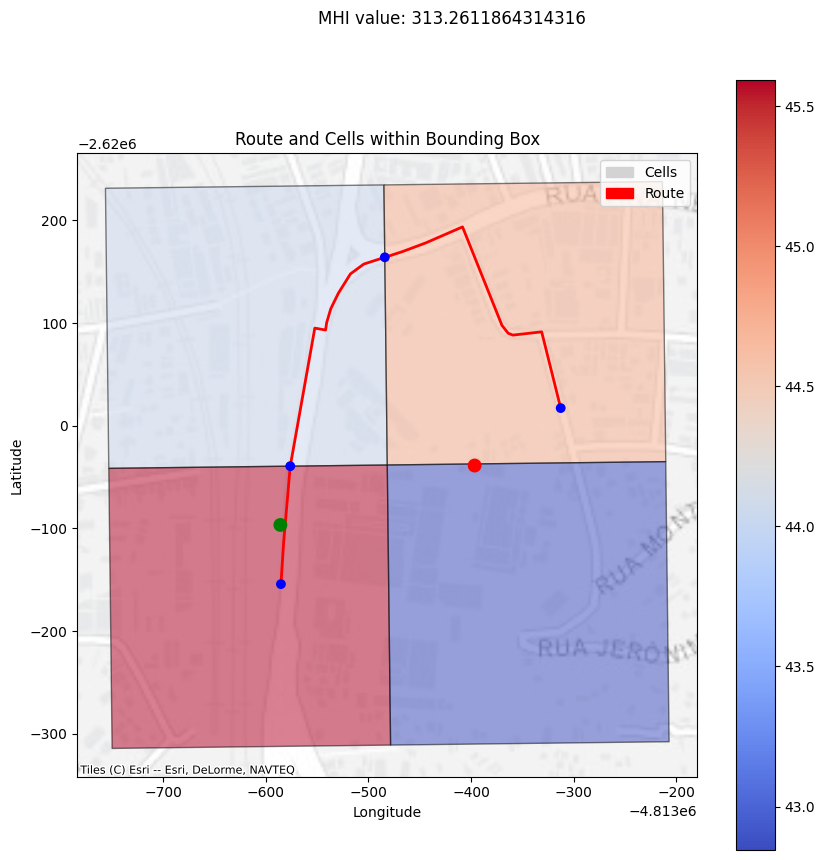

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


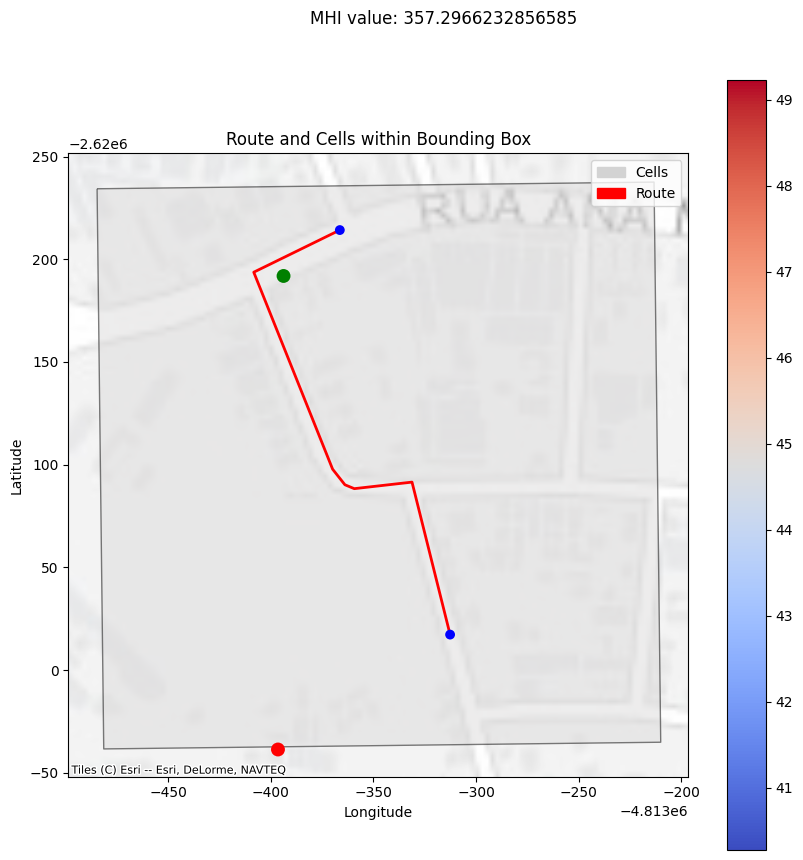

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


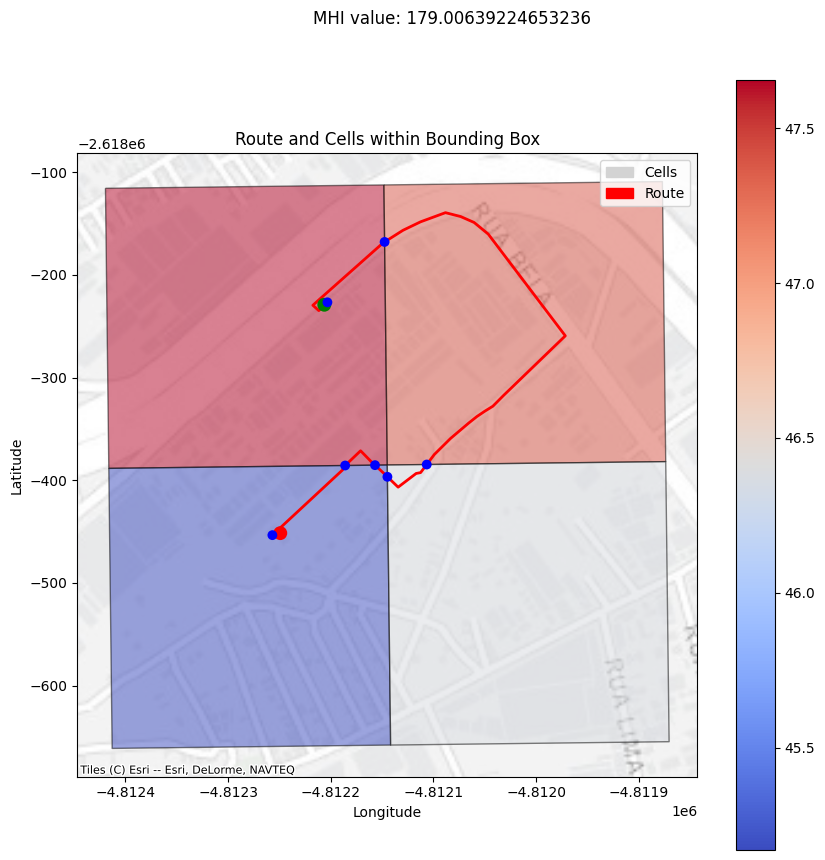

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


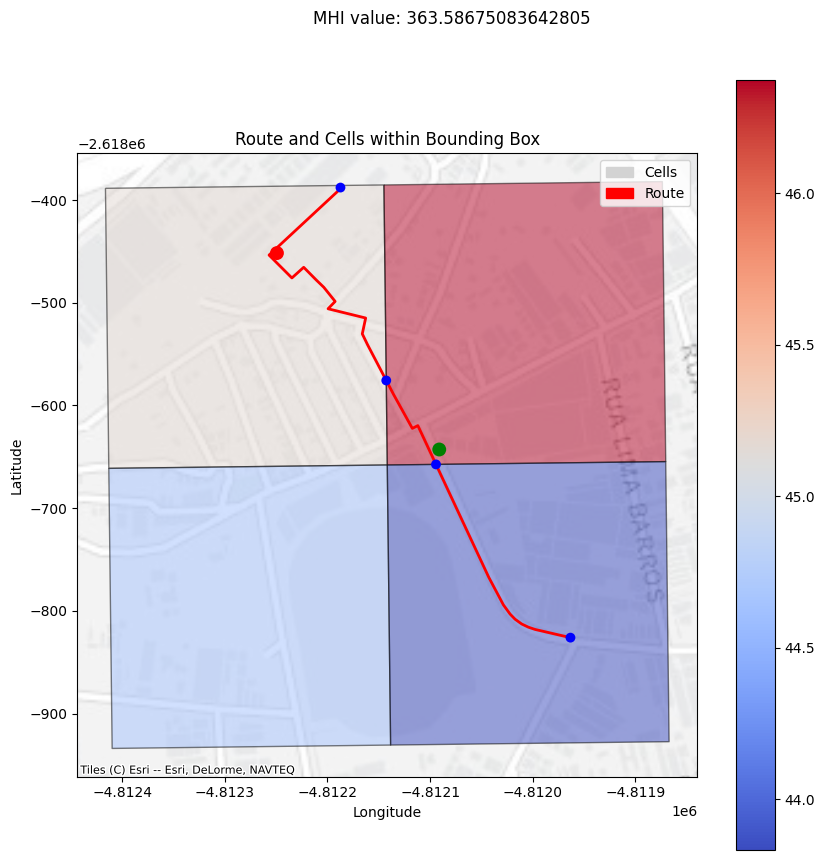

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


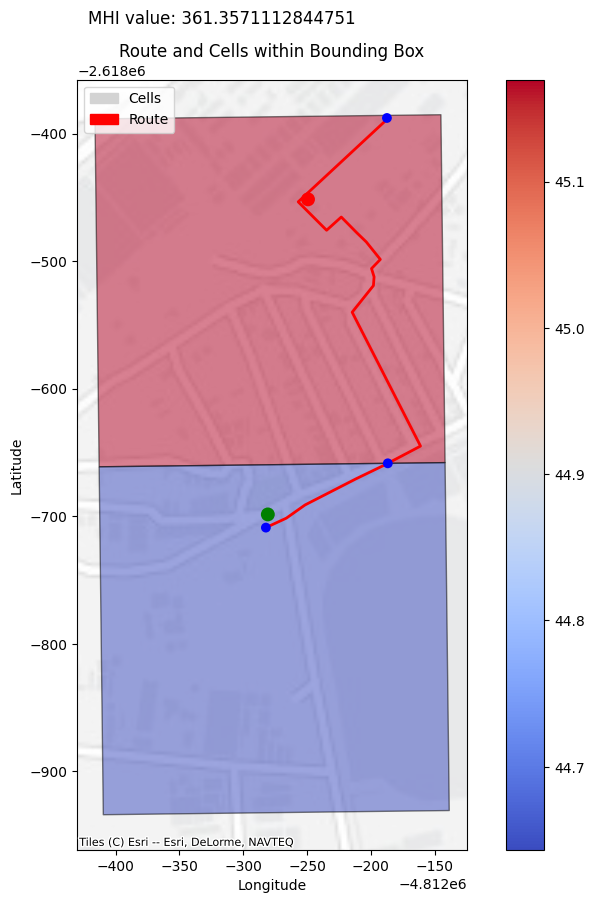

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


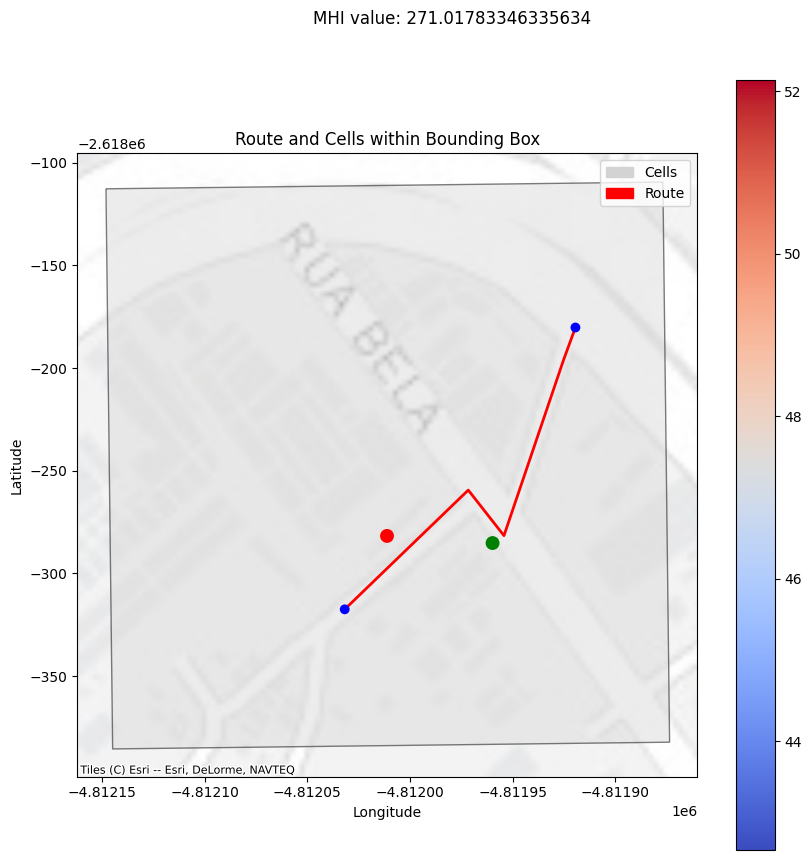

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


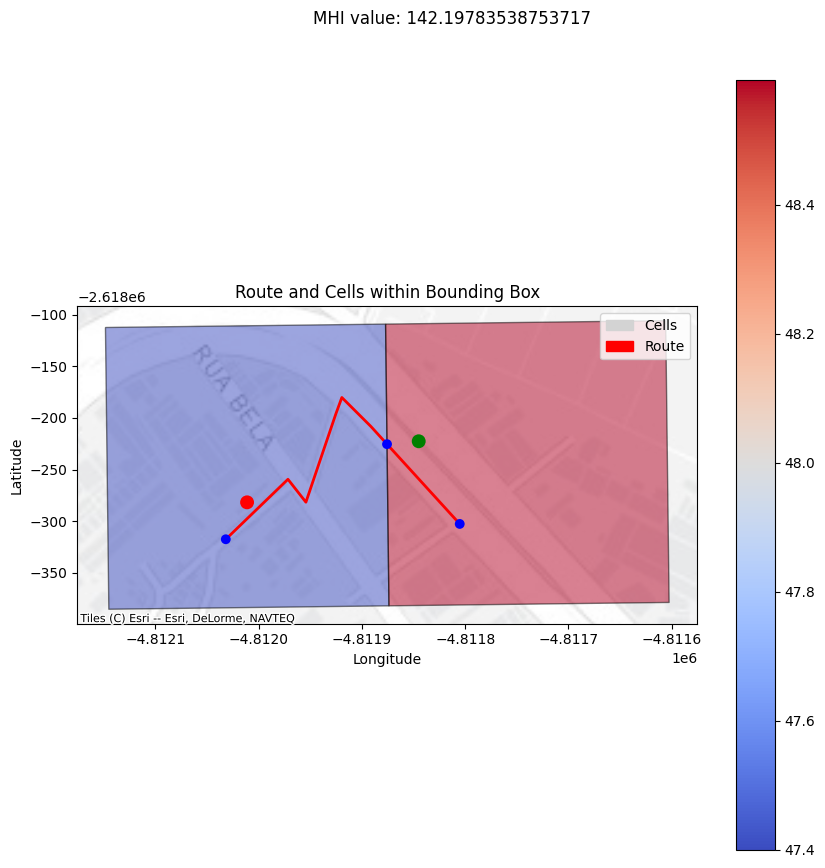

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


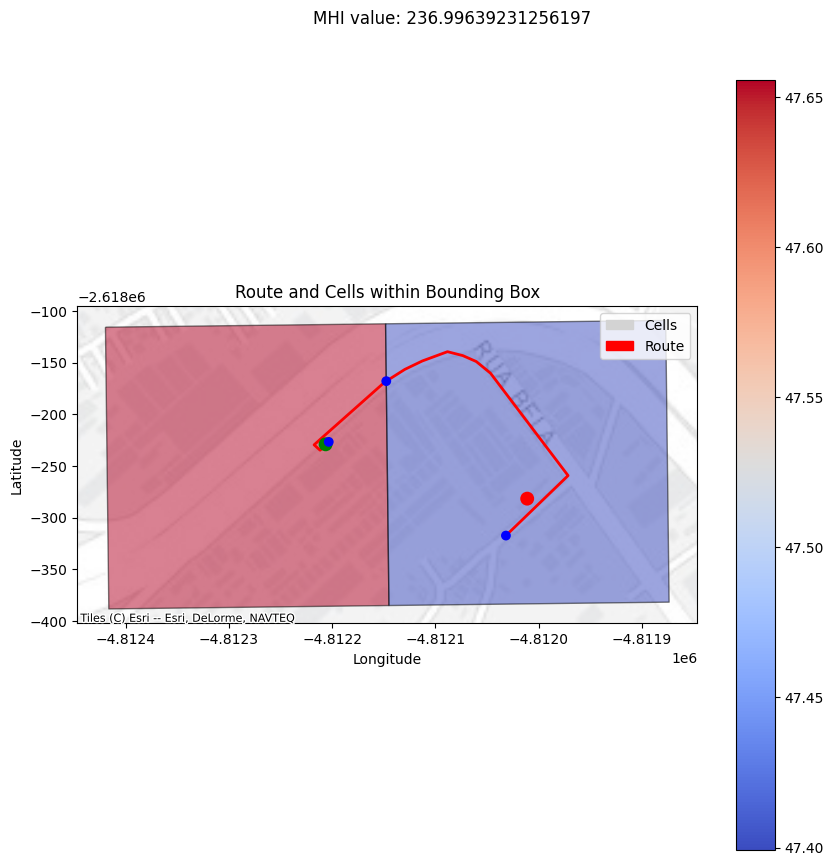

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


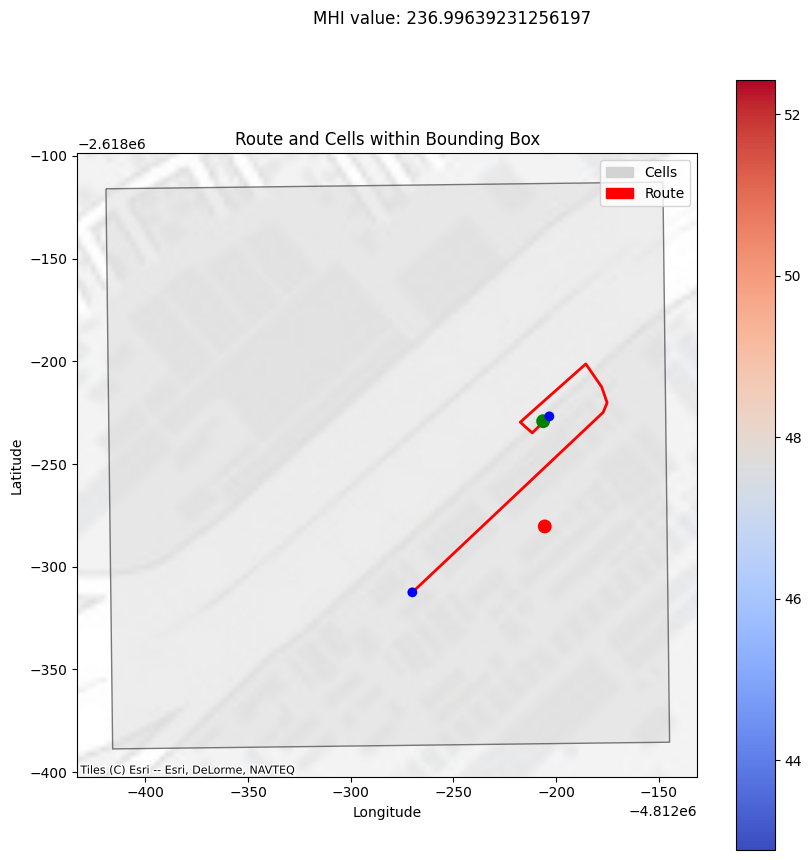

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


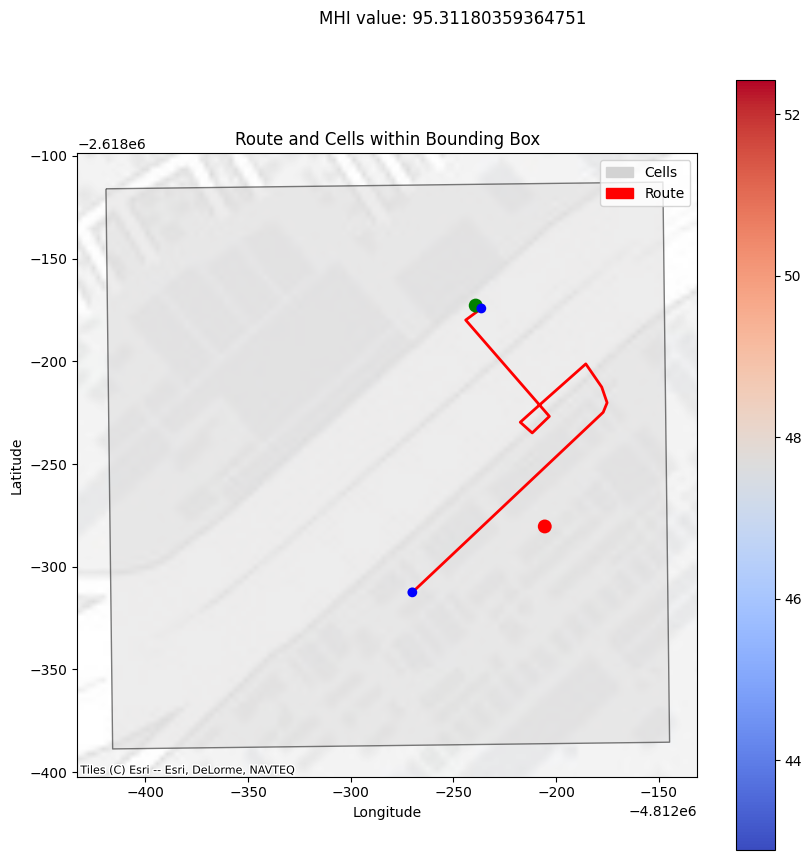

/Users/oleg/Library/Python/3.9/lib/python/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 18 is not valid for the current tile provider (valid zooms: 0 - 16).
  warnings.warn(msg)


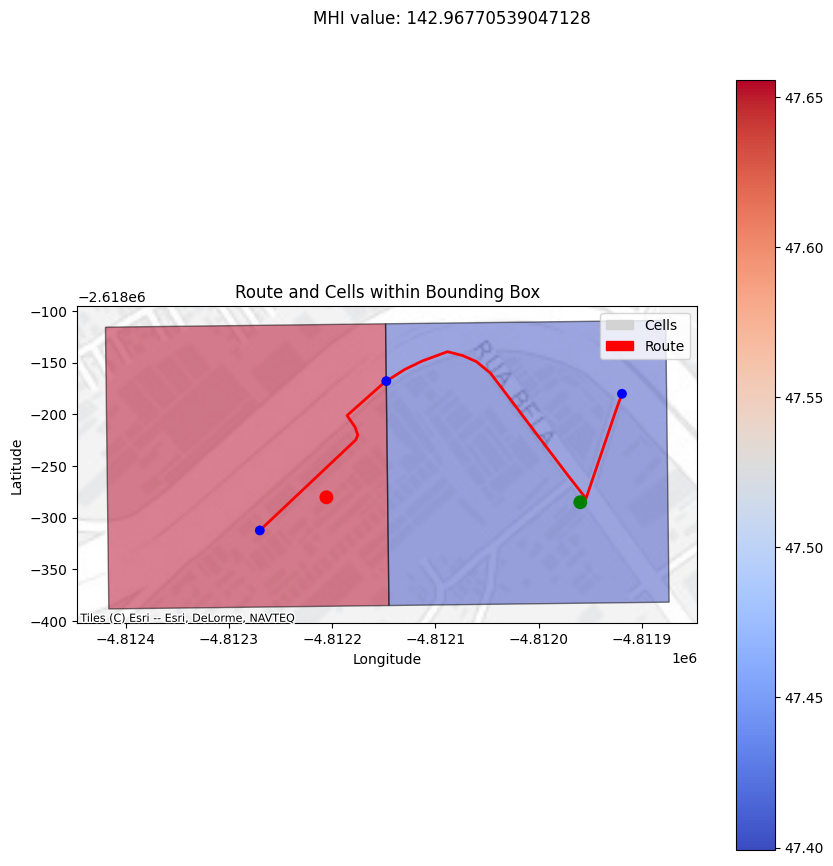

In [33]:
# Read the raster data from the GeoPackage
from shapely.geometry import LineString
from pyproj import Transformer, CRS

raster = gpd.read_file(raster_gpkg_path, layer=raster_layer_name)
raster=raster.to_crs(addresses.crs)

def get_unique_intersections(intersections):
    # Set to track unique intersection points
    seen_points = set()
    unique_intersections = []
    
    for intersection, utci_mean in intersections:
        # Convert intersection point to a hashable type
        if intersection.geom_type == 'Point':
            point_coords = (intersection.x, intersection.y)
        else:
            # For other geometries, use centroid or bounding box
            point_coords = (intersection.centroid.x, intersection.centroid.y)
        
        # Check if the point has been seen
        if point_coords not in seen_points:
            seen_points.add(point_coords)
            unique_intersections.append((intersection, utci_mean))
    
    return unique_intersections

# Function to get the bounding box of the route
def get_bounding_box(route):
    # Define source and target CRS

    #print(route_projected.bounds)
    return route.bounds

# Function to filter cells within the bounding box of the route
def filter_cells_within_bbox(raster, bbox):
    cells=raster[raster.intersects(box(*bbox))]
    #print(cells.shape[0])
    return cells

# Function to get intersection points of the route with cells
def get_intersections(route, cells):
    intersections = []
    test=[]
    start_point = Point(route.coords[0])
    end_point = Point(route.coords[-1])
    #if start_point==end_point:
        #print("start and end of route are the same")
    
    start_included = False
    end_included = False
    
    for cell in cells.itertuples():
        # Check if start point is within the cell
        if cell.geometry.contains(start_point) and not start_included:
            intersections.append((start_point, cell.utci_mean))
            test.append(start_point)
            #print("added start point that is not an intersection")
            start_included = True

        # Check if end point is within the cell
        if cell.geometry.contains(end_point) and not end_included:
            intersections.append((end_point, cell.utci_mean))
            test.append(end_point)
            #print("added end point that is not an intersection")
            end_included = True
        

        # Check for intersections between the route and cell boundaries
        
        if route.intersects(cell.geometry.exterior):
            intersection = route.intersection(cell.geometry.exterior)
            if intersection.is_empty:
                continue
            elif intersection.geom_type == 'Point':
                intersections.append((intersection, cell.utci_mean))
                test.append(intersection)
                #print("Added point")
            elif intersection.geom_type in ['LineString', 'Polygon']:
                print("Warning, seems intersection is a polygon")
                intersections.append((intersection.centroid, cell.utci_mean))
                test.append(intersection)
            elif intersection.geom_type in ['MultiPoint']:
                #print("Multiple intersections with cell")
                for geom in intersection.geoms:
                    intersections.append((geom.centroid if geom.geom_type != 'Point' else geom, cell.utci_mean))    
                    test.append(intersection)
            elif intersection.geom_type in ['MultiLineString', 'MultiPolygon']:
                print("Warning, seems intersection is a multipolygon")
                for geom in intersection.geoms:
                    test.append(intersection)
                    intersections.append((geom.centroid if geom.geom_type != 'Point' else geom, cell.utci_mean))

    
    unique_intersections = get_unique_intersections(intersections)
    #print("of these unique:",len(unique_intersections))
    
    return unique_intersections

# Function to order intersection points from A to B on the route
def order_intersections(route, intersections):
    # Helper function to calculate distance along the segment
    def distance_along_segment(segment_start, segment_end, point):
        segment_line = LineString([segment_start, segment_end])
        return segment_line.project(point)
    
    # Initialize a list to store ordered intersections
    ordered_intersections = []
    #test_seg=[]
    # Iterate through each segment of the route
    for i in range(len(route.coords) - 1):
        segment_start = route.coords[i]
        segment_end = route.coords[i + 1]
        segment_line = LineString([segment_start, segment_end])
        
        buffer_distance = 1e-5
        buffered_segment = segment_line.buffer(buffer_distance)  # Buffer the route
        # Find intersections on the current segment
        segment_intersections = [pt for pt in intersections if buffered_segment.intersects(pt[0])]
        
        # Calculate distance along the segment for each intersection and sort
        segment_intersections_with_distances = [
            (pt, distance_along_segment(segment_start, segment_end, pt[0])) for pt in segment_intersections
        ]
        segment_intersections_sorted = sorted(segment_intersections_with_distances, key=lambda x: x[1])
        
        # Append sorted intersections to the final list
        ordered_intersections.extend([x[0] for x in segment_intersections_sorted])
    #print("ordered intersections:",len(ordered_intersections))
    return ordered_intersections

# Function to calculate travel time between points using r5py
def calculate_travel_time(r5_network, origin, destination, departure):
    origins_gdf = gpd.GeoDataFrame(geometry=[Point(origin)], crs="EPSG:3857")
    origins_gdf.loc[:,'id']=origins_gdf.index
    destinations_gdf = gpd.GeoDataFrame(geometry=[Point(destination)], crs="EPSG:3857")
    destinations_gdf.loc[:,'id']=destinations_gdf.index
    

    travel_computer = r5py.TravelTimeMatrixComputer(
        r5_network,
        origins=origins_gdf,
        destinations=destinations_gdf,
        departure=departure,
        transport_modes=[r5py.TransportMode.WALK],
        snap_to_network=False,
    )
    travel_times = travel_computer.compute_travel_times()
    travel_time = travel_times.loc[0, 'travel_time']
    return travel_time

# Function to calculate mhi
def calculate_mhi(route, raster, r5_network, departure, destination_stop, origin_point):
    bbox = get_bounding_box(route)
    cells_within_bbox = filter_cells_within_bbox(raster, bbox)
    if not cells_within_bbox.empty:
        
        # Get intersections and order them
        intersections = get_intersections(route, cells_within_bbox)
        ordered_intersections = order_intersections(route, intersections)
        
        points_on_route = [pt[0].centroid for pt in ordered_intersections]
        
        #print(len(points_on_route))
        type(points_on_route)
        mhi_list = []
        
        # Initialize lists to store GeoDataFrame data
        dest_point = []
        points = []
        heats = []
        times = []
        dep_point = []
        mhis=[]
        
        #print("length_route",len(points_on_route))
        for p in range(len(points_on_route) - 1):
            origin = points_on_route[p]
            destination = points_on_route[p + 1]
            travel_time = calculate_travel_time(r5_network, origin, destination, departure)
        
            # Ensure valid heat level assignment
            if p == 0:
                heat_level = ordered_intersections[0][1]
            elif p <= len(ordered_intersections):
                heat_level = ordered_intersections[p-1][1]
            else:
                heat_level = ordered_intersections[-1][1]
            
            mhi_list.append(travel_time * heat_level)
            
            # Append data to lists
            dest_point.append(destination)
            points.append(p)
            heats.append(heat_level)
            times.append(travel_time)
            dep_point.append(points_on_route[p])
            mhis.append(sum(mhi_list))
        
        mhi = sum(mhi_list)
        dest_heat= ordered_intersections[-1][1]
        origin_heat= ordered_intersections[0][1]
        
        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame({
            
            'point': points,
            'heat': heats,
            'time': times,
            'origin': dep_point,
            'destination': dest_point,
            'mhi': mhis
        })
        
        #if needed, each route and intersections can be visualized with the function below:
        
        #plot_route_and_cells(route,
        #                     cells_within_bbox,
        #                     destination_point=destination_stop.geometry.iloc[0],
        #                     origin_point=origin_point.geometry.iloc[0],
        #                     intersections=points_on_route)
        return mhi, gdf,dest_heat,origin_heat
        
    else:
        return None, None, None, None


# Create MHI columns in addresses GeoDataFrame
addresses['mhi_1'] = None
addresses['mhi_2'] = None
addresses['mhi_3'] = None
# Create stop columns in addresses GeoDataFrame
addresses['stop_1'] = None
addresses['stop_2'] = None
addresses['stop_3'] = None
# Find the three nearest transport stops for each address
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(transport_stops.geometry.apply(lambda x: (x.x, x.y)).tolist())
distances, indices = nbrs.kneighbors(addresses.geometry.apply(lambda x: (x.x, x.y)).tolist())

#travel_list=[]
addresses.reset_index(drop=True, inplace= True)

# Create GeoDataFrame
mhi_per_route = gpd.GeoDataFrame({
    'point': [],
    'heat': [],
    'time': [],
    'origin': [],
    'destination': [],
    'mhi': []
})

# Calculate routes 
for i in addresses.index:
    origin = addresses.loc[[i]]
    #display(origin.head())
    for j in range(3):
        stop_idx = indices[i, j]
        destination_stop = transport_stops.iloc[[stop_idx]]

        detailed_itineraries_computer = r5py.DetailedItinerariesComputer(
            r5_network,
            origins=origin,
            destinations=destination_stop,
            departure=departure,
            transport_modes=[r5py.TransportMode.WALK],
            snap_to_network=True,
        )
        travel_details = detailed_itineraries_computer.compute_travel_details()
        
        #try:
        route=transform_route(travel_details.geometry.iloc[0])
        mhi,gdf,dest_heat,origin_heat=calculate_mhi(route=route,
                  raster=raster,
                  r5_network=r5_network,
                  departure=departure,
                  destination_stop=destination_stop,
                  origin_point=origin)
        addresses.at[i, f'mhi_{j+1}'] = mhi
        addresses.at[i, f'stop_{j+1}'] = destination_stop.reset_index(drop=True).iloc[0,2]
        addresses.at[i, 'origin_heat'] = origin_heat
        addresses.at[i, 'dest_heat'] = dest_heat
        
        
        
        mhi_per_route=gpd.GeoDataFrame(pd.concat([mhi_per_route, gdf], ignore_index=True))
        #except:
            #print("problems with finding matching cells for address")
            




In [ ]:
mhi_per_route.loc[mhi_per_route['point']>15].head(10)

In [ ]:
print(100*addresses.mhi_1.isna().sum()/addresses.shape[0],"mhi1 percent nulls")
print(100*addresses.mhi_2.isna().sum()/addresses.shape[0],"mhi2 percent nulls")
print(100*addresses.mhi_3.isna().sum()/addresses.shape[0],"mhi3 percent nulls")

In [ ]:
addresses = addresses.set_geometry('original_geometry').set_crs(addresses.crs, allow_override=True)
    
        # Drop the original 'geometry' column which contains address geometries
addresses.drop(columns=['geometry'], inplace=True)
    
    # Rename 'savegeom' to 'geometry' to match expected output
addresses.rename_geometry('geometry', inplace=True)


In [ ]:
addresses.to_file('buildings_mhi.gpkg',driver='gpkg')